In [15]:
from scipy.special import logsumexp
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt

In [16]:
# num_states = number of hidden states
# observations are a series of distributions over states for isolated frames
# transmat is the transition matrix
# prior is the distribution at t=0 (the first observation is ignored)
def make_fwd_lattice(num_states, observations, transmat, prior):
    log_prior = np.log(prior)
    log_observations = np.log(observations)
    log_transmat = np.log(transmat)
    observations = np.array(observations)
    num_observations = observations.shape[0]
    fwdlattice = np.zeros((num_observations, num_states))
    
    fwdlattice[0] = log_prior

    work_buffer = np.zeros(num_states)
    for t, log_observation in enumerate(log_observations[1:], start=1):
        for to_idx in range(num_states):
            for from_idx in range(num_states):
                work_buffer[from_idx] = fwdlattice[t - 1, from_idx] + log_transmat[from_idx, to_idx]
            try:
                fwdlattice[t, to_idx] = logsumexp(work_buffer) + log_observation[to_idx]
            except:
                import pdb; pdb.set_trace()
                pass
    normalized = np.exp(fwdlattice)
    normalized /= normalized.sum(axis=1)[:, np.newaxis]
    normalized[0] = prior
    return fwdlattice, normalized

## 1. Let's verify the implementation is correct

In [17]:
prior = np.array([1., 0.])
transmat = [[1., 1.],
            [0., 1.]]
transmat = np.array(transmat)

observations = list()
observations.append(np.array([0.5, 0.5]))
observations.append(np.array([0.8, 0.2]))
observations.append(np.array([0.8, 0.2]))


fwd_lattice, normalized = make_fwd_lattice(2, observations, transmat, prior)
print('forward lattice:')
print(fwd_lattice)
print('forward lattice in probability space')
print(normalized)
print('\n\nImplementation is verifiably correct!')

forward lattice:
[[ 0.                -inf]
 [-0.22314355 -1.60943791]
 [-0.4462871  -1.60943791]]
forward lattice in probability space
[[1.         0.        ]
 [0.8        0.2       ]
 [0.76190476 0.23809524]]


Implementation is verifiably correct!


## 2. Forward lattice behavior when we give the same input repeatedly

In [18]:
transmat = [[1., 1., 1.],
            [0., 1., 1.],
            [0., 0., 1.]]
transmat = np.array(transmat)
prior = np.array([1., 0., 0.])

#### 2a) Given the same frame over and over, the distribution skews to the right

In [19]:
transmat = [[1., 1., 1.],
            [0., 1., 1.],
            [0., 0., 1.]]
transmat = np.array(transmat)
prior = np.array([1., 0., 0.])

In [20]:
observation = np.array([0.6, 0.3, 0.1])
observations = np.array([observation for _ in range(3)])
fwd_lattice, normalized = make_fwd_lattice(3, observations, transmat, prior)

print('We would expect the fwdlattice to be very confident the state of the robot is [0.6, 0.3, 0.1]')
print('The actual distribution is:', normalized[-1])


We would expect the fwdlattice to be very confident the state of the robot is [0.6, 0.3, 0.1]
The actual distribution is: [0.49315068 0.36986301 0.1369863 ]


#### 2b) The distribution gets quickly driven toward a stationary distribution

In [21]:
observation = np.array([0.6, 0.3, 0.1])
observations = np.array([observation for _ in range(25)])
fwd_lattice, normalized = make_fwd_lattice(3, observations, transmat, prior)

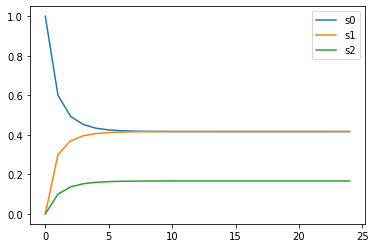

In [22]:
plt.plot(normalized[:, 0])
plt.plot(normalized[:, 1])
plt.plot(normalized[:, 2])
plt.legend(['s0', 's1', 's2'])

In [23]:
#### The same graph, but with expected values plotted as well

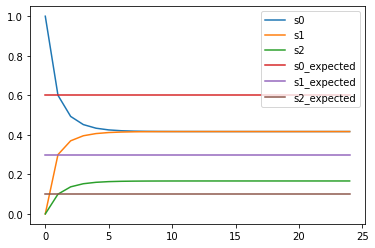

In [24]:
plt.plot(normalized[:, 0])
plt.plot(normalized[:, 1])
plt.plot(normalized[:, 2])
plt.plot(np.full_like(normalized[:, 0], 0.6))
plt.plot(np.full_like(normalized[:, 0], 0.3))
plt.plot(np.full_like(normalized[:, 0], 0.1))
plt.legend(['s0', 's1', 's2', 's0_expected', 's1_expected', 's2_expected'])

### 2c) We make some progress in a few frames, and then make some negative progress: Plot viterbi reward vs per-frame reward

In [25]:
def reward_from_distribution(distribution):
    loss = (distribution * np.arange(len(distribution) - 1, -1, -1)).sum()
    max_loss = len(distribution) - 1
    reward = 1 - loss / max_loss
    return reward

In [26]:
observations = list()
observations.append(np.array([1., 0., 0.]))
observations.append(np.array([0.9, 0.1, 0.]))
observations.append(np.array([0.8, 0.15, 0.05]))
observations.append(np.array([0.7, 0.2, 0.1]))
observations.append(np.array([0.5, 0.4, 0.1]))
observations.append(np.array([0.25, 0.6, 0.15]))
observations.append(np.array([0.2, 0.4, 0.4]))
observations.append(np.array([0.1, 0.2, 0.7]))
observations.append(np.array([0.05, 0.05, 0.9]))
observations.append(np.array([0.1, 0.2, 0.7]))
observations.append(np.array([0.2, 0.4, 0.4]))
observations.append(np.array([0.25, 0.6, 0.15]))
observations.append(np.array([0.5, 0.4, 0.1]))
observations.append(np.array([0.7, 0.2, 0.1]))
observations.append(np.array([0.8, 0.15, 0.05]))
observations.append(np.array([0.9, 0.1, 0.]))
fwd_lattice, normalized = make_fwd_lattice(3, observations, transmat, prior)

### The reward is very inflated! It becomes more inflated over time, and decays VERY slowly when the observed distribution shifts to the left

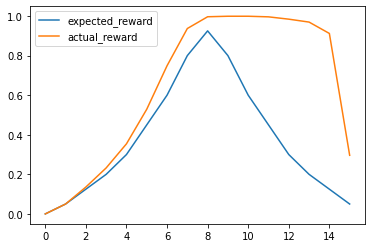

In [27]:
expected_reward = [reward_from_distribution(distribution) for distribution in observations]
actual_reward = [reward_from_distribution(distribution) for distribution in normalized]
plt.plot(expected_reward)
plt.plot(actual_reward)
plt.legend(['expected_reward', 'actual_reward'])


### 2d) Plot log likelihood over time for the above example
Vertical line denotes peak on the plot above, where we start making negative progress.


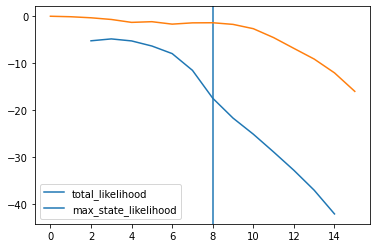

In [28]:
total_likelihood = fwd_lattice.sum(axis=1)
most_likely = np
plt.plot(total_likelihood)
most_likely_state_likelihood = np.max(fwd_lattice, axis=1)
plt.axvline(x=8)
plt.plot(most_likely_state_likelihood)
plt.legend(['total_likelihood', 'max_state_likelihood'])